# Zombie Firms Checker

Identify Zombie Firms based on Siauwijaya (2021) Master's dissertation at the University of Glasgow

** Methods are sourced from Banerjee et al. (2018) and Cella (2020) **

In [1]:
import pandas as pd
import numpy as np

In [2]:
dFull = pd.read_excel('ICR_Dummy.xlsx', sheet_name = 'forPythonMod')
dFull

,Ticker,Company Common Name,TRBC Economic Sector Name,1997,1998,1999,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,SAMF.JK,Saraswanti Anugerah Makmur PT,Basic Materials,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,CITA.JK,Cita Mineral Investindo Tbk PT,Basic Materials,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0
2,INAI.JK,Indal Aluminium Industry Tbk PT,Basic Materials,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALMI.JK,Alumindo Light Metal Industry Tbk PT,Basic Materials,NaN,NaN,NaN,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
4,ALKA.JK,Alakasa Industrindo Tbk PT,Basic Materials,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,LAPD.JK,Leyand International Tbk PT,Utilities,NaN,NaN,NaN,NaN,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
673,MPOW.JK,MegaPower Makmur Tbk PT,Utilities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
674,PGAS.JK,Perusahaan Gas Negara Tbk PT,Utilities,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0
675,SURE.JK,Super Energy Tbk PT,Utilities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0


In [3]:
dfx = dFull.drop(['Ticker','Company Common Name','TRBC Economic Sector Name'], axis=1) # drop first 3 columns
dfx = dfx.where(pd.notnull(dfx), None) # convert n.a to None

In [4]:
dfxDo = {}
for i in range(0,len(dfx)):
    slc = dfx.iloc[:, 0+i : 3+i]
    for name in slc:
        dfxDo[name] = pd.DataFrame(slc)

In [5]:
dfxD = {}
for col,df in dfxDo.items():
    #rename the n (dictionary name)
    colNam = df.columns[-1]
    dfxD[colNam] = dfxDo[col]

dfxD[2019] = dfxDo[2017]

In [6]:
dfxDict = {}
for key, df in dfxD.items():
    # dd = dataframe inside dictionary
    dd = dfxD[key] # make a variable for every dictionary key (quarters)
    dd['sum'] = dd.sum(axis=1,min_count=1) # sum all of the value in dataframe for every quarter
    dd['sumNull'] = pd.isnull(dd['sum']) # create boolean checker for 'sum' column || 'sumnull' = is sum null?
    dd['isNullCheckdf'] = dd.isnull().any(axis=1) # create boolean checker for the whole df columns
    
    # change dataframe n.a to None
    dd = dd.where(pd.notnull(dd), None)
    
    # zombie checker
    conditions = [
    (dd['sum'] == 3), # Zombie == 3 Year in a row ICR <1
    (dd['sum'] != 3) & (dd['sumNull'] == False) & (dd['isNullCheckdf'] == False) , # NotZombie == ICR Not <1 3 years in a row & ICR sum data not empty & NO MISSING DATA IN DF
    (dd['sum'] != 3) & (dd['sumNull'] == False) & (dd['isNullCheckdf'] == True), # UnClass == ICR Not <1 3 years in a row & ICR sum data not empty & MISSING DATA IN DF
    (dd['sumNull'] == True) & (dd['isNullCheckdf'] == True)] # Set value 1 if the sum of row null AND there is a null value inside
    
    choices = ['Zombie', 'notZombie', 'unClass', 'noData']
    dd['zString'] = np.select(conditions, choices)
    
    # dummy variable vectors
    dd['zDum'] = np.where(dd['zString'] == 'Zombie',1,0)
    dd['nzDum'] = np.where(dd['zString'] == 'notZombie',1,0)
    dd['ucDum'] = np.where(dd['zString'] == 'unClass',1,0)
    dd['noData'] = np.where(dd['zString'] == 'noData',1,0)
    
    # input dd inside new dictionary
    dfxDict[key] = dd

In [7]:
# Display one of the newly created DataFrame
dfxDict[2004]

,2002,2003,2004,sum,sumNull,isNullCheckdf,zString,zDum,nzDum,ucDum,noData
0,None,None,None,None,True,True,noData,0,0,0,1
1,None,None,None,None,True,True,noData,0,0,0,1
2,None,None,None,None,True,True,noData,0,0,0,1
3,1,1,1,3,False,False,Zombie,1,0,0,0
4,None,None,0,0,False,True,unClass,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
672,1,1,0,2,False,False,notZombie,0,1,0,0
673,None,None,None,None,True,True,noData,0,0,0,1
674,None,0,0,0,False,True,unClass,0,0,1,0
675,None,None,None,None,True,True,noData,0,0,0,1


***

# Make the Zombie Share Dataframe

In [8]:
# function for calculating zombies
# return zombie, notzombie, unclassified, and nodata sum
def zombieCalc(dfName, quarter):
    '''calculate the zombie firms in a calendar quarter'''
    dfQ = dfName[quarter]
    
    zombie = dfQ['zDum'].sum()
    notZombie = dfQ['nzDum'].sum()
    unClassified = dfQ['ucDum'].sum()
    availData = zombie + notZombie + unClassified
    noData = dfQ['noData'].sum()

    zomShare = (zombie/len(dfQ.index))*100
    nzShare = (notZombie/len(dfQ.index))*100
    ucShare = (unClassified/len(dfQ.index))*100
    ndShare = (noData/len(dfQ.index))*100
    
    zomAvail = (zombie/(availData))*100
    zomAvailXuc = (zombie/(zombie + notZombie))*100
    
    print("\n[Summary Statistics] Zombie Firms in {}\n".format(quarter))
    print('Number of Zombie: ' + str(zombie))
    print('Number of Non-Zombie: ' + str(notZombie))
    print('Number of Unclassifiable Firms: ' + str(unClassified))
    print('Number of Empty Data: ' + str(noData))

    print('\nShare of Zombie Firms: ' + str(zomShare)+' Percent' + ' (all data including Null Value)')
    print('Share of Non-Zombie: ' + str(nzShare)+' Percent')
    print('Share of Unclassifiable Firms: ' + str(ucShare)+' Percent')
    print('Share of Empty Data: ' + str(ndShare)+' Percent')
    
    print('\nShare of Zombie Firms (all available data): ' + str(zomAvail)+' Percent')
    print('Share of Zombie Firms (zombie + notZombie data only): ' + str(zomAvailXuc)+' Percent')
    
    print('\n==================####==================\n')
    
    # return a list from all data
    return[zombie,notZombie,unClassified,availData,noData,zomShare,nzShare,ucShare,ndShare,zomAvail,zomAvailXuc]

In [9]:
# Summary statistics for Zombie Firms in 2004
zombieCalc(dfxDict, 2004)


[Summary Statistics] Zombie Firms in 2004

Number of Zombie: 35
Number of Non-Zombie: 85
Number of Unclassifiable Firms: 50
Number of Empty Data: 507

Share of Zombie Firms: 5.1698670605613 Percent (all data including Null Value)
Share of Non-Zombie: 12.55539143279173 Percent
Share of Unclassifiable Firms: 7.385524372230429 Percent
Share of Empty Data: 74.88921713441654 Percent

Share of Zombie Firms (all available data): 20.588235294117645 Percent
Share of Zombie Firms (zombie + notZombie data only): 29.166666666666668 Percent

==================####==================



[35,
 85,
 50,
 170,
 507,
 5.1698670605613,
 12.55539143279173,
 7.385524372230429,
 74.88921713441654,
 20.588235294117645,
 29.166666666666668]

In [10]:
# for loop to repeat the zombieCalc function for display in a table
row = {}
for key,df in dfxDict.items():
    row[key] = zombieCalc(dfxDict, key)


[Summary Statistics] Zombie Firms in 1999

Number of Zombie: 1
Number of Non-Zombie: 13
Number of Unclassifiable Firms: 28
Number of Empty Data: 635

Share of Zombie Firms: 0.14771048744460857 Percent (all data including Null Value)
Share of Non-Zombie: 1.9202363367799113 Percent
Share of Unclassifiable Firms: 4.13589364844904 Percent
Share of Empty Data: 93.79615952732644 Percent

Share of Zombie Firms (all available data): 2.380952380952381 Percent
Share of Zombie Firms (zombie + notZombie data only): 7.142857142857142 Percent

==================####==================


[Summary Statistics] Zombie Firms in 2000

Number of Zombie: 4
Number of Non-Zombie: 25
Number of Unclassifiable Firms: 45
Number of Empty Data: 603

Share of Zombie Firms: 0.5908419497784343 Percent (all data including Null Value)
Share of Non-Zombie: 3.6927621861152145 Percent
Share of Unclassifiable Firms: 6.646971935007386 Percent
Share of Empty Data: 89.06942392909897 Percent

Share of Zombie Firms (all availabl

In [11]:
# create the table for displaying all of the zombie firms calculation results
zs = pd.DataFrame(row)
zs.rename(index = {0:'zombie',1:'notZombie',
                   2:'unClassified',3:'availData',4:'noData',
                   5:'zomShare',6:'nzShare',7:'ucShare',8:'ndShare',
                   9:'zomAvail',10:'zomAvailXuc'},inplace = True)
zs = zs.transpose()

zs

,zombie,notZombie,unClassified,availData,noData,zomShare,nzShare,ucShare,ndShare,zomAvail,zomAvailXuc
1999,1.0,13.0,28.0,42.0,635.0,0.147710,1.920236,4.135894,93.796160,2.380952,7.142857
2000,4.0,25.0,45.0,74.0,603.0,0.590842,3.692762,6.646972,89.069424,5.405405,13.793103
2001,12.0,27.0,79.0,118.0,559.0,1.772526,3.988183,11.669129,82.570162,10.169492,30.769231
2002,13.0,56.0,68.0,137.0,540.0,1.920236,8.271787,10.044313,79.763663,9.489051,18.840580
2003,27.0,83.0,38.0,148.0,529.0,3.988183,12.259970,5.612999,78.138848,18.243243,24.545455
2004,35.0,85.0,50.0,170.0,507.0,5.169867,12.555391,7.385524,74.889217,20.588235,29.166667
2005,39.0,91.0,49.0,179.0,498.0,5.760709,13.441654,7.237814,73.559823,21.787709,30.000000
2006,36.0,113.0,34.0,183.0,494.0,5.317578,16.691285,5.022157,72.968981,19.672131,24.161074
2007,36.0,123.0,30.0,189.0,488.0,5.317578,18.168390,4.431315,72.082718,19.047619,22.641509
2008,21.0,146.0,39.0,206.0,471.0,3.101920,21.565731,5.760709,69.571640,10.194175,12.574850


<b>Note: zomAvail is converted to zomShare in the dissertation</b>

This include the "Data_CausesModel" and "Data_ConsequencesModel" of both .xlsx and .dta file

Reason: zomAvail reflect the share of zombie firms in the IDX better compared zomShare in the above table

In [12]:
### export the above dataFrame to excel ###

# zs.to_excel('zombieShare_Output.xlsx')

---

# Data Visualisation

<u>Visualising "zomShare" data used in the dissertation</u>

(zomAvail is changed into zomShare in the paper)

In [13]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Zombie Share (%)')

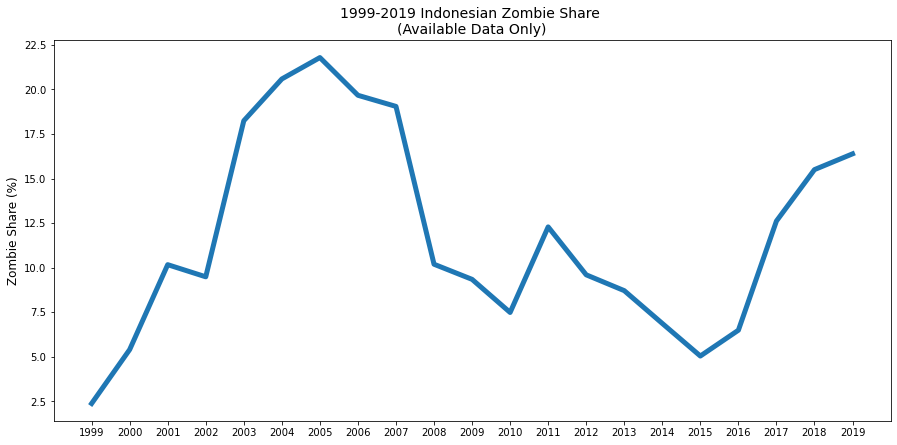

In [14]:
plt.figure(figsize=(15,7))

plt.plot(zs.index, 
         zs['zomAvail'],
        linewidth = 5.0)

plt.xticks(np.arange(1999, 2020, step=1))

plt.title('1999-2019 Indonesian Zombie Share \n(Available Data Only)', fontsize = 14)
plt.ylabel('Zombie Share (%)', fontsize = 12)

---

# [APPENDIX] || Zombie Firm Status - Excel Exporter 

This section of the script was once part of the dissertation. However, this script is no longer needed due to updates in the research methodology. Nevertheless, the author has decided to leave the script here because future research may find this useful.

** The script denotes firms qualified as zombie at time-t as "1" or "0" if else **

In [15]:
d1999 = dfxDict[1999].rename(columns={'zDum': '1999'})
d2000 = dfxDict[2000].rename(columns={'zDum': '2000'})
d2001 = dfxDict[2001].rename(columns={'zDum': '2001'})
d2002 = dfxDict[2002].rename(columns={'zDum': '2002'})
d2003 = dfxDict[2003].rename(columns={'zDum': '2003'})
d2004 = dfxDict[2004].rename(columns={'zDum': '2004'})
d2005 = dfxDict[2005].rename(columns={'zDum': '2005'})
d2006 = dfxDict[2006].rename(columns={'zDum': '2006'})
d2007 = dfxDict[2007].rename(columns={'zDum': '2007'})
d2008 = dfxDict[2008].rename(columns={'zDum': '2008'})
d2009 = dfxDict[2009].rename(columns={'zDum': '2009'})
d2010 = dfxDict[2010].rename(columns={'zDum': '2010'})
d2011 = dfxDict[2011].rename(columns={'zDum': '2011'})
d2012 = dfxDict[2012].rename(columns={'zDum': '2012'})
d2013 = dfxDict[2013].rename(columns={'zDum': '2013'})
d2014 = dfxDict[2014].rename(columns={'zDum': '2014'})
d2015 = dfxDict[2015].rename(columns={'zDum': '2015'})
d2016 = dfxDict[2016].rename(columns={'zDum': '2016'})
d2017 = dfxDict[2017].rename(columns={'zDum': '2017'})
d2018 = dfxDict[2018].rename(columns={'zDum': '2018'})
d2019 = dfxDict[2019].rename(columns={'zDum': '2019'})

In [16]:
zomdf = dFull[['Ticker','Company Common Name','TRBC Economic Sector Name']].copy()
zomdf['1999'] = d1999['1999'].copy()
zomdf['2000'] = d2000['2000'].copy()
zomdf['2001'] = d2001['2001'].copy()
zomdf['2002'] = d2002['2002'].copy()
zomdf['2003'] = d2003['2003'].copy()
zomdf['2004'] = d2004['2004'].copy()
zomdf['2005'] = d2005['2005'].copy()
zomdf['2006'] = d2006['2006'].copy()
zomdf['2007'] = d2007['2007'].copy()
zomdf['2008'] = d2008['2008'].copy()
zomdf['2009'] = d2009['2009'].copy()
zomdf['2010'] = d2010['2010'].copy()
zomdf['2011'] = d2011['2011'].copy()
zomdf['2012'] = d2012['2012'].copy()
zomdf['2013'] = d2013['2013'].copy()
zomdf['2014'] = d2014['2014'].copy()
zomdf['2015'] = d2015['2015'].copy()
zomdf['2016'] = d2016['2016'].copy()
zomdf['2017'] = d2017['2017'].copy()
zomdf['2018'] = d2018['2018'].copy()
zomdf['2019'] = d2019['2019'].copy()

zomdf

,Ticker,Company Common Name,TRBC Economic Sector Name,1999,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,SAMF.JK,Saraswanti Anugerah Makmur PT,Basic Materials,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CITA.JK,Cita Mineral Investindo Tbk PT,Basic Materials,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,INAI.JK,Indal Aluminium Industry Tbk PT,Basic Materials,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ALMI.JK,Alumindo Light Metal Industry Tbk PT,Basic Materials,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
4,ALKA.JK,Alakasa Industrindo Tbk PT,Basic Materials,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,LAPD.JK,Leyand International Tbk PT,Utilities,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
673,MPOW.JK,MegaPower Makmur Tbk PT,Utilities,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
674,PGAS.JK,Perusahaan Gas Negara Tbk PT,Utilities,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
675,SURE.JK,Super Energy Tbk PT,Utilities,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [17]:
### export the above dataFrame to excel ###

# zomdf.to_excel('zomDummyAll.xlsx')

---

# End of the Notebook

---